In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models
from datetime import datetime
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import time

import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


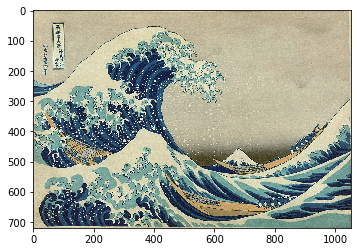

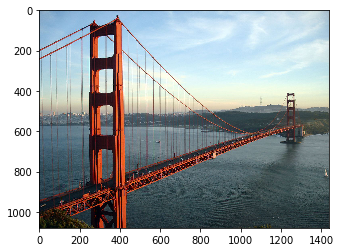

In [3]:
torch.cuda.empty_cache()
if device.type == "cuda":
    #imsize = 512
    imsize = 256
    #imsize = 384
else:
    imsize = 128

img_transforms = transforms.Compose([transforms.Resize([imsize, imsize])
                                    , transforms.ToTensor()
                                    #, transforms.Lambda(lambda x:x.div_(255))
                                    , transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                    #,transforms.Lambda(lambda x:x[torch.LongTensor([2,1,0])]),
                                    ]
                                   )

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    img = img_transforms(img).unsqueeze(0)
    return img.to(device, torch.float)

plt.figure()
style_img = load_image("/home/gaurav/Deep Learning/GreatWaveOffKanagawa1052px.jpg")
plt.figure()
content_img = load_image("/home/gaurav/Deep Learning/GoldenGateBridge1440px.jpg")

print(style_img.size(), content_img.size())

assert style_img.size() == content_img.size()

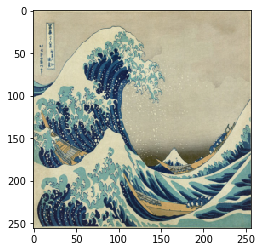

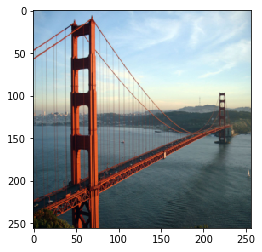

array([[[0.49019606, 0.61176473, 0.73333338],
        [0.4980392 , 0.61960786, 0.73333338],
        [0.51764707, 0.63529413, 0.74509809],
        ...,
        [0.69019609, 0.76470589, 0.80392161],
        [0.67843138, 0.7490196 , 0.79215691],
        [0.6627451 , 0.73333334, 0.77647063]],

       [[0.4980392 , 0.61960786, 0.74117651],
        [0.5137255 , 0.63529413, 0.74901964],
        [0.52156864, 0.64313727, 0.75294121],
        ...,
        [0.68627451, 0.76078431, 0.80784316],
        [0.67058824, 0.7490196 , 0.79607846],
        [0.65882353, 0.7372549 , 0.78431375]],

       [[0.50980394, 0.63137257, 0.75294121],
        [0.52549021, 0.64705883, 0.76078434],
        [0.53725491, 0.65882355, 0.76470592],
        ...,
        [0.68235294, 0.76470589, 0.81568632],
        [0.67058824, 0.75294119, 0.80392161],
        [0.65490197, 0.7372549 , 0.78823533]],

       ...,

       [[0.01568629, 0.04313725, 0.02745099],
        [0.01960783, 0.04705884, 0.02745099],
        [0.08235292, 0

In [4]:
plt.ion()

def img_show(tensor, title=None):
    img = tensor.cpu().clone().detach()
    img = img.numpy().squeeze()
    img = img.transpose(1,2,0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    #img = transforms.ToPILImage()(img)
    #print(type(img))
    plt.imshow(img)
    plt.pause(0.001)
    return img
    
plt.figure()
img_show(style_img)

plt.figure()
img_show(content_img)

In [5]:
#vgg_directory = "./vgg_conv.pth"

vgg19 = torchvision.models.vgg19(pretrained=True).features
vgg19.to(device)
print(vgg19)

#print(len(vgg19))
for i in range(len(vgg19)):
    if isinstance(vgg19[i], nn.MaxPool2d):
        vgg19[i] = nn.AvgPool2d(vgg19[i].kernel_size, vgg19[i].stride)

print(vgg19)
        
for param in vgg19.parameters():
    param.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
def content_cost(c_img, g_img):
    m, n_C, n_H, n_W = list(c_img.size())
    
    c_img_unrolled = c_img.view((m, n_H*n_W, n_C))
    g_img_unrolled = g_img.view((m, n_H*n_W, n_C))
    
    J_content = torch.sum(torch.pow(c_img_unrolled - g_img_unrolled, 2))/2

    return J_content

In [7]:
def gram_matrix(mat):
    return torch.matmul(mat, mat.t())

In [8]:
def style_cost_layer(s_img, g_img):
    m, n_C, n_H, n_W = list(s_img.size())
    
    s_img_unrolled = s_img.view((n_C, -1))
    g_img_unrolled = g_img.view((n_C, -1))
    
    s_img_gram_matrix = gram_matrix(s_img_unrolled)
    g_img_gram_matrix = gram_matrix(g_img_unrolled)
       
    J_style_layer = torch.sum(torch.pow(s_img_gram_matrix - g_img_gram_matrix, 2))/2
    
    return J_style_layer    

In [9]:
def total_variation_loss(img):
    m, n_C, n_H, n_W = list(img.size())
    tv_H = (torch.pow(img[:,:,1:,:] - img[:,:,:-1,:], 2)).sum()
    tv_W = (torch.pow(img[:,:,:,1:] - img[:,:,:,:-1], 2)).sum()
    
    return tv_H + tv_W
    #return torch.sqrt(tv_H) + torch.sqrt(tv_H)

In [10]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'2': 'conv1_2',
                 '7': 'conv2_2',
                 '12': 'conv3_2',
                 '19': 'conv4_1',
                 '30': 'conv5_2'}
        
    features = {}
    x = image
    #print(model._modules['features'])
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [11]:
content_img.to(device)
style_img.to(device)

content_layers = None
#content_layers = {'23':'conv4_3'}
content_features = get_features(content_img, vgg19, layers=content_layers)
style_features = get_features(style_img, vgg19)

#style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

In [12]:
#target = torch.randn_like(content_img).requires_grad_(True).to(device)
target = content_img.clone().requires_grad_(True).to(device)

In [13]:
style_weights = {'conv1_2':1,
                'conv2_2':0.9,
                'conv3_2':0.6,
                'conv4_1':0.4,
                'conv5_2':0.4
                }

#TODO: content_weight=5
content_weight = 5

#TODO: style_weight=2000
style_weight = 2000
#TODO: tv_weight=10
tv_weight = 10

In [14]:
# optimizer = optim.Adam([target], lr=0.05)
optimizer = optim.Adam([target], lr=0.03)

Iteration 100


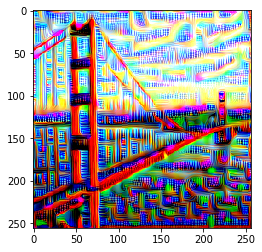

Iteration 200


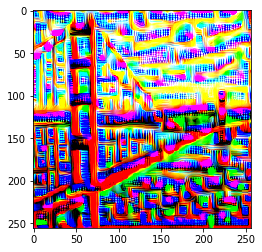

KeyboardInterrupt: 

In [15]:
content_loss_list = []
style_loss_list = []
tv_loss_list = []

start_time = time.time()

for i in range(1, 1701):
    #iter_start_time = time.time()
    optimizer.zero_grad()
    
    target_features = get_features(target, vgg19)
    if content_layers == None:
        content_loss = content_cost(content_features['conv3_2'], target_features['conv3_2'])
        #content_loss = content_cost(content_features['conv4_4'], target_features['conv4_4'])
        #content_loss = content_cost(content_features['conv2_2'], target_features['conv2_2'])
    else:
        target_content_features = get_features(target, vgg19, content_layers)
        content_loss = content_cost(content_features['conv4_3'], target_content_features['conv4_3'])
            
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        m, n_C, n_H, n_W = target_feature.size()
        style_feature = style_features[layer]
        layer_style_loss = style_weights[layer] * style_cost_layer(style_feature, target_feature)
        style_loss += layer_style_loss/(4*n_H*n_W*n_C)
    
    variation_loss = total_variation_loss(target)
    
    total_loss = (content_weight * content_loss) + (style_weight * style_loss) + (tv_weight * variation_loss)
    total_loss.backward()
    optimizer.step()
    
    content_loss_item = content_weight*content_loss.item()
    style_loss_item = style_weight*style_loss.item()
    tv_loss_item = tv_weight*variation_loss.item()
    
    content_loss_list.append(content_loss_item)
    style_loss_list.append(style_loss_item)
    tv_loss_list.append(tv_loss_item)
    
    if i%100==0:
        '''total_loss_rounded = round(total_loss.item(), 2)
        content_loss_item = content_weight*content_loss.item()
        style_loss_item = style_weight*style_loss.item()
        tv_loss_item = tv_weight*variation_loss.item()
        content_loss_proportion = round(content_loss_item/total_loss.item(), 2)
        style_loss_proportion = round(style_loss_item/total_loss.item(), 2)
        tv_loss_proportion = round(tv_loss_item/total_loss.item(), 2)
        iter_end_time = time.time()
        
        print("Iteration {} - Total Loss: {}, Content Loss: {}, Style Loss: {}, TV Loss: {}"
              .format(i, total_loss_rounded, round(content_loss_item,2), round(style_loss_item,2), round(tv_loss_item,2)) +  
              " Content Loss%: {}, Style Loss%: {}, TV Loss% : {}"
              .format(content_loss_proportion, style_loss_proportion, tv_loss_proportion))
        print("Time required: {}".format(iter_end_time-iter_start_time))'''
        
        print("Iteration {}".format(i))
        plt.figure()
        final_target = img_show(target)
    
    '''if i==1500:
        curr_time = str(datetime.now())
        fin_img = final_target * 255
        fin_img = fin_img.astype(np.uint8)
        fin_img = Image.fromarray(fin_img)
        fin_img.save("/home/gaurav/Deep Learning/NeuralStyleTransferResults/"+curr_time+".png")'''
        
end_time = time.time()
print("Time taken for processing : {}".format(round(end_time-start_time, 2)))
final_img = final_target

In [ ]:
iterations = np.arange(1700)
#content_loss_list_normalized = [x/content_weight for x in content_loss_list]
#style_loss_list_normalized = [x/style_weight for x in style_loss_list]
#tv_loss_list_normalized = [x/tv_weight for x in tv_loss_list]


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(iterations, content_loss_list, label='content_loss')
ax1.plot(iterations, style_loss_list, label='style_loss')
ax1.plot(iterations, tv_loss_list, label='tv_loss')

ax2.plot(iterations[300:], content_loss_list[300:], label='content_loss')
ax2.plot(iterations[300:], style_loss_list[300:], label='style_loss')
ax2.plot(iterations[300:], tv_loss_list[300:], label='tv_loss')
#plt.plot(iterations, content_loss_list_normalized[300:2000], label='content_loss_normalized')
#plt.plot(iterations, style_loss_list_normalized[300:2000], label='style_loss_normalized')
#plt.plot(iterations, tv_loss_list_normalized[300:2000], label='tv_loss_normalized')

plt.legend(['content_loss', 'style_loss', 'tv_loss'])#, 'content_loss_norm', 'style_loss_norm', 'tv_loss_norm'])

In [ ]:
curr_time = str(datetime.now())
fin_img = final_img * 255
fin_img = fin_img.astype(np.uint8)
fin_img = Image.fromarray(fin_img)
fin_img.save("/home/gaurav/Deep Learning/NeuralStyleTransferResults/"+curr_time+".png")
#save_image(final_img, fp="/home/gaurav/Deep Learning/NeuralStyleTransferResults/"+curr_time+".png")
#plt.gcf()
#plt.savefig("/home/gaurav/Deep Learning/NeuralStyleTransferResults/"+curr_time+".png")
plt.figure()
img_show(content_img)
img_show(style_img)
plt.figure()
plt.imshow(final_img)